In [1]:
from interaction_inference import simulation
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import tqdm
import numpy as np
from interaction_inference.constraints import Constraint
from interaction_inference.optimization import Optimization
from interaction_inference.dataset import Dataset

In [2]:
rng = np.random.default_rng(1)

# Moment analytic constraints (package test)

Added constraints equating moment variables to analytic expressions in terms of model parameters, test to see improved performance in feasibility tests

# Code

Telegraph dataset with range of gene values

In [54]:
def simulate_dataset_range_TE(name, gene_values, cells=1000, interaction=0.0, rate=1, tqdm_disable=True):
    '''
    Produce a dataset of pairs of samples with fixed parameters (rate) over a
    range of gene on values.

    Args:
        cells: number of samples to simulate per gene-pair
        interaction_values: k_reg parameters values to simulate samples for
        rate: k_tx parameter values for all genes

    Returns:
        Dataset instance containing information as attributes

        params_df: pandas dataframe of model parameters per gene-pair
        counts_df: pandas dataframe of sampled counts per gene-pair
    '''

    # number of pairs
    gene_pairs = len(gene_values)

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # for each gene
    for i in tqdm.tqdm(range(gene_pairs), disable=tqdm_disable):

        # Set reaction rate parameters
        k_on_1 = gene_values[i]
        k_on_2 = gene_values[i]
        k_off_1 = 1 - gene_values[i]
        k_off_2 = 1 - gene_values[i]
        k_tx_1 = rate
        k_tx_2 = rate
        k_deg_1 = 1
        k_deg_2 = 1
        k_reg = interaction

        # store parameters
        params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_on_1': k_on_1,
            'k_on_2': k_on_2,
            'k_off_1': k_off_1,
            'k_off_2': k_off_2,
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # simulate sample from model
        sample = simulation.gillespie_telegraph(params, cells)

        # store counts
        counts_df.iloc[i] = sample

    # construct dataset object
    data = Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = len(gene_values)
    data.beta = np.array([1.0 for j in range(cells)])

    return data

Int BD, Indep TE, Int TE grids

In [55]:
def simulate_gridtest_interacting_BD(mean_capture_values, interaction_values, runs, rate, cells=1000):

    # store data
    data_list = []

    # simulate sample
    data = simulation.simulate_dataset_range_BD(
        name = "gridtest",
        interaction_values = interaction_values * runs,
        cells = cells,
        rate = rate,
        tqdm_disable = False
    )

    # for each capture
    for i, m in enumerate(mean_capture_values):

        # beta parameter
        b = (1 / m) - 1

        # capture vector
        if b == 0:
            beta = np.ones(cells)
        else:
            beta = rng.beta(1, b, size=cells)

        # downsample
        data_downsampled = data.downsample("gridtest", beta)

        # bootstrap
        data_downsampled.compute_moments(tqdm_disable=True)

        # adjust truncation
        for sample, trunc in data_downsampled.moment_extent_OG.items():
            max_x1_OG = trunc['max_x1_OG']
            max_x2_OG = trunc['max_x2_OG']
            data_downsampled.moment_extent_OG[sample]['max_x1_OG'] = max(100, max_x1_OG)
            data_downsampled.moment_extent_OG[sample]['max_x2_OG'] = max(100, max_x2_OG)

        data_list.append(data_downsampled)

    return data_list

In [56]:
def simulate_gridtest_independent_TE(mean_capture_values, gene_values, runs, rate, cells=1000):

    # store data
    data_list = []

    # simulate sample
    data = simulate_dataset_range_TE(
        name = "gridtest",
        gene_values = gene_values * runs,
        cells = cells,
        rate = rate,
        tqdm_disable = False
    )

    # for each capture
    for i, m in enumerate(mean_capture_values):

        # beta parameter
        b = (1 / m) - 1

        # capture vector
        if b == 0:
            beta = np.ones(cells)
        else:
            beta = rng.beta(1, b, size=cells)

        # downsample
        data_downsampled = data.downsample("gridtest", beta)

        # bootstrap
        data_downsampled.compute_moments(tqdm_disable=True)

        # adjust truncation
        for sample, trunc in data_downsampled.moment_extent_OG.items():
            max_x1_OG = trunc['max_x1_OG']
            max_x2_OG = trunc['max_x2_OG']
            data_downsampled.moment_extent_OG[sample]['max_x1_OG'] = max(100, max_x1_OG)
            data_downsampled.moment_extent_OG[sample]['max_x2_OG'] = max(100, max_x2_OG)

        data_list.append(data_downsampled)

    return data_list

In [57]:
def simulate_gridtest_interacting_TE(mean_capture_values, interaction_values, runs, rate, gene=0.5, cells=1000):

    # store data
    data_list = []

    # simulate sample
    data = simulation.simulate_dataset_range_TE(
        name = "gridtest",
        interaction_values = interaction_values * runs,
        cells = cells,
        rate = rate,
        gene = gene,
        tqdm_disable = False
    )

    # for each capture
    for i, m in enumerate(mean_capture_values):

        # beta parameter
        b = (1 / m) - 1

        # capture vector
        if b == 0:
            beta = np.ones(cells)
        else:
            beta = rng.beta(1, b, size=cells)

        # downsample
        data_downsampled = data.downsample("gridtest", beta)

        # bootstrap
        data_downsampled.compute_moments(tqdm_disable=True)

        # adjust truncation
        for sample, trunc in data_downsampled.moment_extent_OG.items():
            max_x1_OG = trunc['max_x1_OG']
            max_x2_OG = trunc['max_x2_OG']
            data_downsampled.moment_extent_OG[sample]['max_x1_OG'] = max(100, max_x1_OG)
            data_downsampled.moment_extent_OG[sample]['max_x2_OG'] = max(100, max_x2_OG)

        data_list.append(data_downsampled)

    return data_list

Optimization over grid

In [58]:
def optimize_gridtest(data_list, constraints, mean_capture_values, grid_values, runs):

    # result arrays
    result_array = np.zeros((len(mean_capture_values), len(grid_values)))

    # for each capture
    for i, m in enumerate(mean_capture_values):

        print(f"{i + 1} / {len(mean_capture_values)}")

        # get data
        data = data_list[i]
    
        # optimize
        opt = Optimization(data, constraints, tqdm_disable=True, print_solution=False)

        # store results
        for j, solution in opt.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array[i, j % result_array.shape[1]] += 1 / runs

    return result_array

Plotting gridtest

In [64]:
def plot_gridtest(result_array, mean_capture_values, grid_values, model_name, constraint_name, axis_label):

    fig, axs = plt.subplots(figsize=(10, 6))

    #plt.tight_layout()

    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('br',["b", "w", "r"], N=256) 

    vmin, vmax = 0, 1

    # new
    img = axs.imshow(result_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel(f"{axis_label}")
    axs.set_xticks(range(len(grid_values)))
    axs.set_xticklabels(grid_values)
    axs.set_ylabel("Mean capture efficiency (beta distributed)")
    axs.set_yticks(range(len(mean_capture_values)))
    axs.set_yticklabels(mean_capture_values)
    axs.set_title(f"{constraint_name}")

    fig.suptitle(f"{model_name} model infeasibility % across range of parameters")

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label("Infeasibility %")

# Independent Birth Death feasibility test

## Interacting birth death gridtest

Test interaction detection performance of new moment constraints

In [60]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 3

# parameters
rate = 5
cells = 1000

# simulate gridtest
data_int_BD = simulate_gridtest_interacting_BD(mean_capture_values, interaction_values, runs, rate)

100%|██████████| 30/30 [02:29<00:00,  5.00s/it]


In [61]:
# full constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_IBD           = True,
    marginal_CME_1       = True,
    marginal_CME_2       = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
result_full = optimize_gridtest(data_int_BD, constraints, mean_capture_values, interaction_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [71]:
# only moment constraints (no probability)
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_factorization = True,
    moment_IBD           = True
)

# optimize
result_moment = optimize_gridtest(data_int_BD, constraints, mean_capture_values, interaction_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


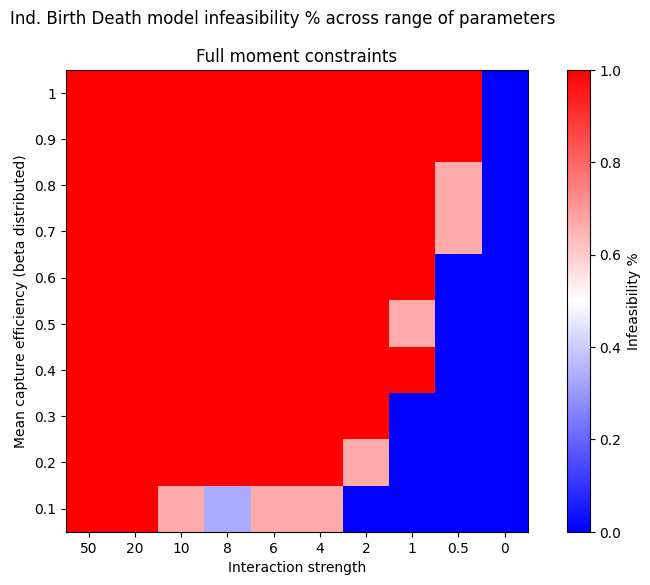

In [72]:
plot_gridtest(result_full, mean_capture_values, interaction_values, "Ind. Birth Death", "Full moment constraints", "Interaction strength")

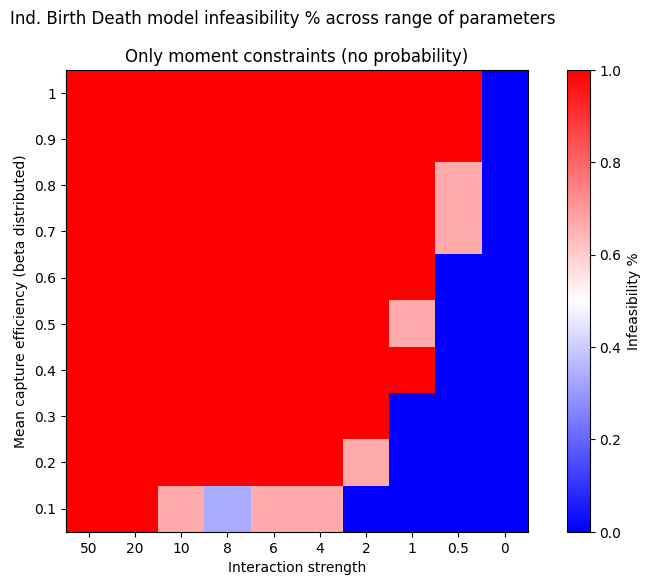

In [75]:
plot_gridtest(result_moment, mean_capture_values, interaction_values, "Ind. Birth Death", "Only moment constraints (no probability)", "Interaction strength")

Very good performance
- right column (ind BD data) all feasible (no false positive issues)
- left columns (int BD data) infeasible except for low capture & low interaction (very good detection)

Removing probability constraints (moment -> prob link & CME & parameter fixing) makes no difference to the results, the key constraint here is moment factorization (assumes independence). Removing the analytic moment constraint (moment_IBD) slightly weakens results, so is still used.

In [121]:
# no analytic moment constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_IBD           = False,
    marginal_CME_1       = True,
    marginal_CME_2       = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
result_nany = optimize_gridtest(data_int_BD, constraints, mean_capture_values, interaction_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


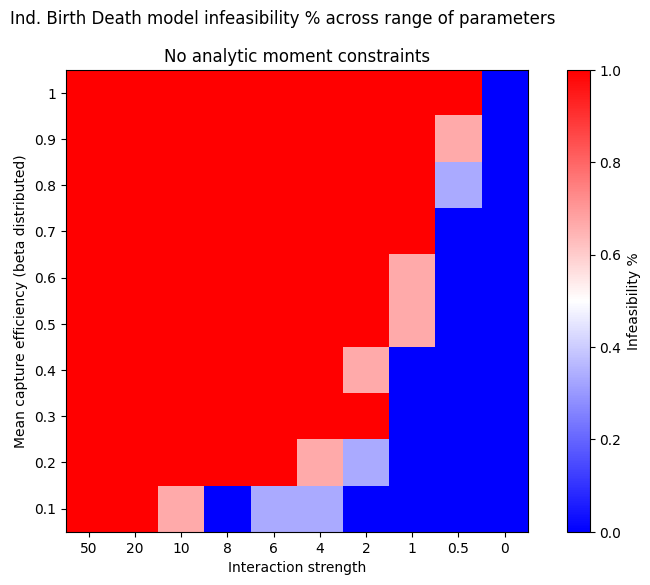

In [122]:
plot_gridtest(result_nany, mean_capture_values, interaction_values, "Ind. Birth Death", "No analytic moment constraints", "Interaction strength")

For interaction detection, removing analytic moment constraints only slightly weakens results.

## Independent telegraph gridtest

Test model detection performance of new moment constraints

In [76]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
gene_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
runs = 3

# parameters
rate = 5
cells = 1000

# simulate gridtest
data_ind_TE = simulate_gridtest_independent_TE(mean_capture_values, gene_values, runs, rate)

100%|██████████| 30/30 [01:50<00:00,  3.67s/it]


In [77]:
# full constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_IBD           = True,
    marginal_CME_1       = True,
    marginal_CME_2       = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
result_full = optimize_gridtest(data_ind_TE, constraints, mean_capture_values, gene_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [81]:
# only moment constraints (no probability)
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_factorization = True,
    moment_IBD           = True
)

# optimize
result_moment = optimize_gridtest(data_ind_TE, constraints, mean_capture_values, gene_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


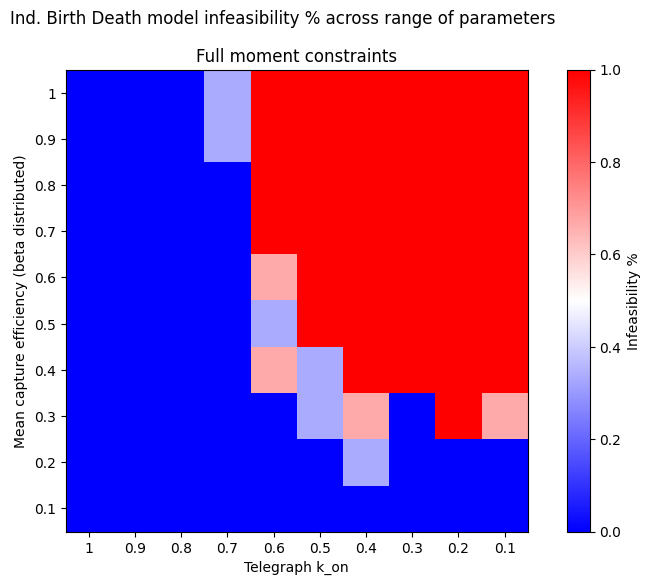

In [79]:
plot_gridtest(result_full, mean_capture_values, gene_values, "Ind. Birth Death", "Full moment constraints", "Telegraph k_on")

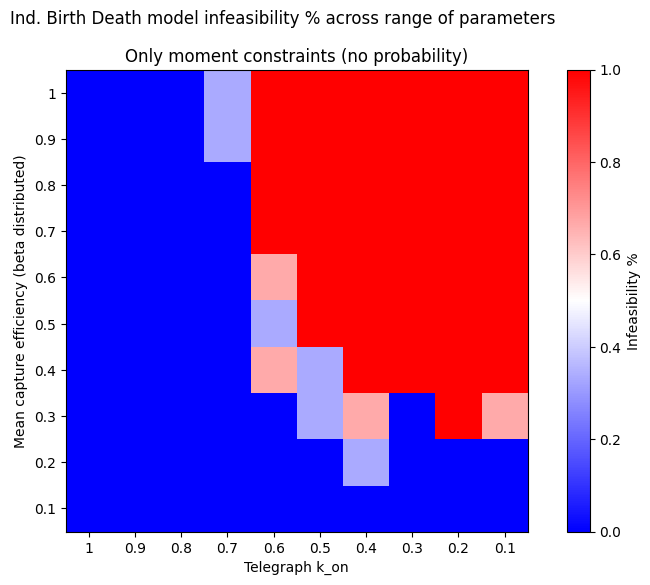

In [82]:
plot_gridtest(result_moment, mean_capture_values, gene_values, "Ind. Birth Death", "Only moment constraints (no probability)", "Telegraph k_on")

Good performance
- left column (ind BD data) all feasible (no false positive issues)
- right columns (ind TE data) often infeasible except for low capture or high k_on (TE close to BD)

Removing probability constraints (moment -> prob link & CME & paramter fixing) makes no difference to the results, the key constraint here is analytic expressions of moments in terms of model parameters (to enforce model structure). Removing the moment factorization constraint slightly weakens results, so still used.

In [123]:
# no analytic moment constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_IBD           = False,
    marginal_CME_1       = True,
    marginal_CME_2       = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
result_nany = optimize_gridtest(data_ind_TE, constraints, mean_capture_values, gene_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


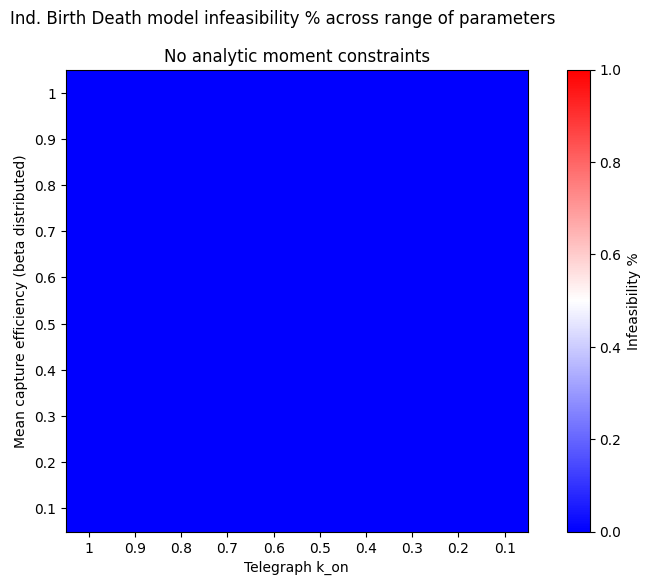

In [124]:
plot_gridtest(result_nany, mean_capture_values, gene_values, "Ind. Birth Death", "No analytic moment constraints", "Telegraph k_on")

Analytic moment constraints are essential for model detection, removing them means all cases are now feasible.

___

Overall we see the moment perform very well for independent BD feasibility test:
- very good interaction detection
- good model detection

Removing probability constraints does not change results (even removing the CME!), and overall the key constraints are moment factorization (enforce independence) and analytic moment expressions (enforce model structure).

When removing analytic moment expressions (keeping all other constraints) we see interaction detection is almost unchanged, but model detection is non-existent. This is concerning, as suggests we cannot test feasibility of models where analytic moment expressions are not available.

# Independent Telegraph feasibility test

## Interacting telegraph gridtest

In [83]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 3

# parameters
rate = 5
gene = 0.5
cells = 1000

# simulate gridtest
data_int_TE = simulate_gridtest_interacting_TE(mean_capture_values, interaction_values, runs, rate, gene=gene)

100%|██████████| 30/30 [01:24<00:00,  2.83s/it]


In [84]:
# construct constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_ITE           = True,
    marginal_CME_TE      = True,
    marginal_TE_equality = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
result_full = optimize_gridtest(data_int_TE, constraints, mean_capture_values, interaction_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [85]:
# construct constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_factorization = True,
    moment_ITE           = True,
)

# optimize
result_moment = optimize_gridtest(data_int_TE, constraints, mean_capture_values, interaction_values, runs)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


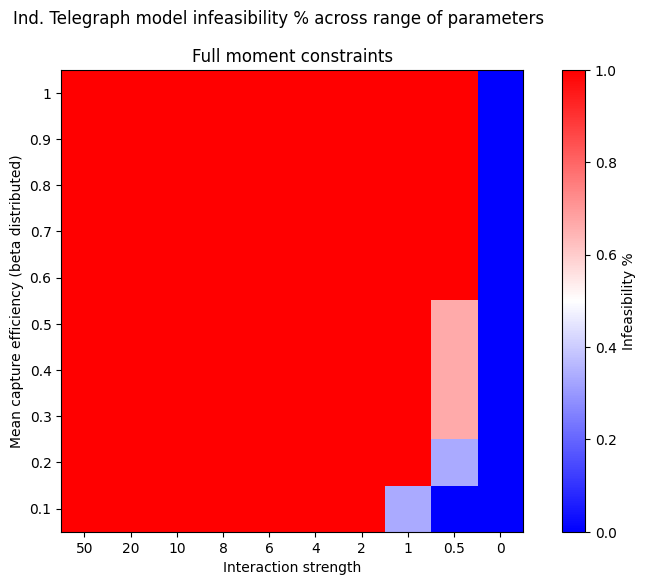

In [88]:
plot_gridtest(result_full, mean_capture_values, interaction_values, "Ind. Telegraph", "Full moment constraints", "Interaction strength")

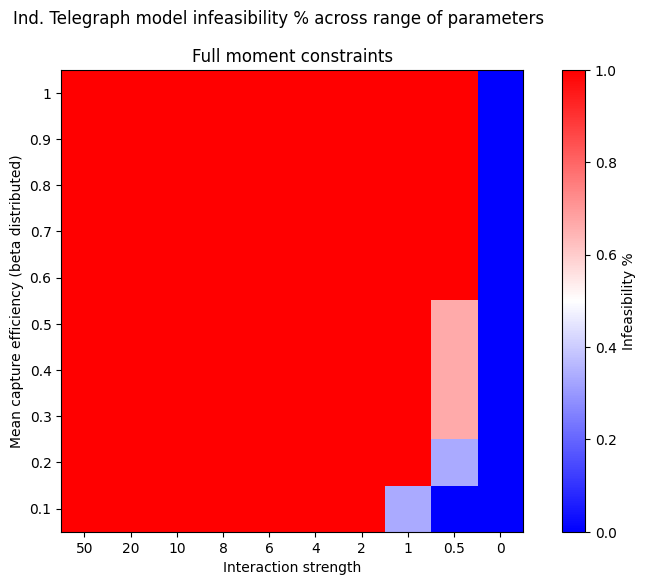

In [89]:
plot_gridtest(result_moment, mean_capture_values, interaction_values, "Ind. Telegraph", "Full moment constraints", "Interaction strength")

Like the independent birth death interaction test, we see very good performance (even better here, perhaps gene leads to higher interaction relative to expression level (as gene off sometimes)), and no change when removing probability constraints.

## Independent non-telegraph data

Investigate model detection performance of independent telegraph feasibility test by attempting to simulate (independent) non-telegraph data.

The telegraph model is a very general model, so try sampling from a multi-modal distribution:

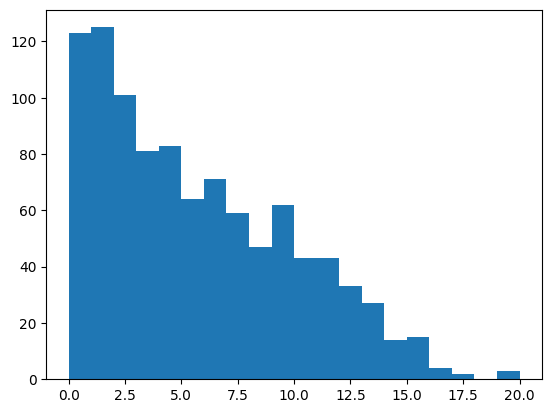

In [106]:
y = rng.choice([1, 5, 10], size=1000)
x = rng.poisson(y)
plt.hist(x, bins=20);

In [107]:
def construct_non_telegraph_dataset(lams, cells=1000, genes=10):

    # dataframes
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(genes)], columns=[f"Cell-{j}" for j in range(cells)])

    # fill
    for g in range(genes):

        # sample
        y1 = rng.choice(lams, size=cells)
        x1 = rng.poisson(y1)

        y2 = rng.choice(lams, size=cells)
        x2 = rng.poisson(y2)

        # pair
        paired_sample = list(zip(x1, x2))

        # store
        counts_df.iloc[g] = paired_sample

    # construct dataset object
    data = Dataset("Non-Telegraph")

    # store information
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = genes
    data.beta = np.array([1.0 for j in range(cells)])

    return data

In [115]:
# simulate sample
data = construct_non_telegraph_dataset(lams=[1, 5, 10], cells=1000, genes=3)

In [116]:
# downsample
m = 1.0
b = (1 / m) - 1
if b == 0:
    beta = np.ones(1000)
else:
    beta = rng.beta(1, b, size=1000)
data_downsampled = data.downsample("test", beta)

In [117]:
# bootstrap
data_downsampled.compute_moments(tqdm_disable=False)

100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


In [118]:
# adjust truncation
for sample, trunc in data_downsampled.moment_extent_OG.items():
    max_x1_OG = trunc['max_x1_OG']
    max_x2_OG = trunc['max_x2_OG']
    data_downsampled.moment_extent_OG[sample]['max_x1_OG'] = max(100, max_x1_OG)
    data_downsampled.moment_extent_OG[sample]['max_x2_OG'] = max(100, max_x2_OG)

In [119]:
# construct constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_ITE           = True,
    marginal_CME_TE      = True,
    marginal_TE_equality = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
opt = Optimization(data_downsampled, constraints, tqdm_disable=True, print_solution=True)

Optimization status: OPTIMAL
Runtime: 6.365000009536743


KeyboardInterrupt: 

# Testing

## Birth Death

In [20]:
# simulate sample
data = simulation.simulate_dataset_range_BD(
    name = "test",
    interaction_values = [5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0], #[50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0],
    cells = 1000,
    rate = 1,
    tqdm_disable = False
)

100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


In [21]:
# downsample
m = 0.9
b = (1 / m) - 1
if b == 0:
    beta = np.ones(1000)
else:
    beta = rng.beta(1, b, size=1000)
data_downsampled = data.downsample("test", beta)

In [22]:
# bootstrap
data_downsampled.compute_moments(tqdm_disable=False)

100%|██████████| 11/11 [00:00<00:00, 12.66it/s]


In [23]:
# adjust truncation
for sample, trunc in data_downsampled.moment_extent_OG.items():
    max_x1_OG = trunc['max_x1_OG']
    max_x2_OG = trunc['max_x2_OG']
    data_downsampled.moment_extent_OG[sample]['max_x1_OG'] = max(100, max_x1_OG)
    data_downsampled.moment_extent_OG[sample]['max_x2_OG'] = max(100, max_x2_OG)

In [24]:
# construct constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = False,
    moment_factorization = False,
    moment_IBD           = True,
    marginal_CME_1       = False,
    marginal_CME_2       = False,
    k_deg_1              = False,
    k_deg_2              = False
)

# optimize
opt = Optimization(data_downsampled, constraints, tqdm_disable=True, print_solution=True)

Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.005000114440917969
Optimization status: OPTIMAL
Runtime: 0.003000020980834961
Optimization status: OPTIMAL
Runtime: 0.006000041961669922
Optimization status: OPTIMAL
Runtime: 0.003999948501586914
Optimization status: OPTIMAL
Runtime: 0.006999969482421875
Optimization status: OPTIMAL
Runtime: 0.002000093460083008
Optimization status: OPTIMAL
Runtime: 0.003999948501586914
Optimization status: OPTIMAL
Runtime: 0.0010001659393310547
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.0


## Telegraph

In [3]:
# simulate sample
data = simulation.simulate_dataset_range_TE(
    name = "test",
    interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0],
    cells = 1000,
    rate = 5,
    gene = 0.5,
    tqdm_disable = False
)

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


In [14]:
# downsample
m = 0.5
b = (1 / m) - 1
if b == 0:
    beta = np.ones(1000)
else:
    beta = rng.beta(1, b, size=1000)
data_downsampled = data.downsample("test", beta)

In [15]:
# bootstrap
data_downsampled.compute_moments(tqdm_disable=False)

100%|██████████| 10/10 [00:01<00:00,  9.80it/s]


In [16]:
# adjust truncation
for sample, trunc in data_downsampled.moment_extent_OG.items():
    max_x1_OG = trunc['max_x1_OG']
    max_x2_OG = trunc['max_x2_OG']
    data_downsampled.moment_extent_OG[sample]['max_x1_OG'] = max(100, max_x1_OG)
    data_downsampled.moment_extent_OG[sample]['max_x2_OG'] = max(100, max_x2_OG)

In [17]:
# construct constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_ITE           = True,
    marginal_CME_TE      = True,
    marginal_TE_equality = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
opt = Optimization(data_downsampled, constraints, tqdm_disable=True, print_solution=True)#, silent=False, compute_IIS=True, write_model=True)

Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.016000032424926758
Optimization status: INFEASIBLE
Runtime: 0.004000186920166016
Optimization status: INFEASIBLE
Runtime: 0.002000093460083008
Optimization status: INFEASIBLE
Runtime: 0.0009999275207519531
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 25.905999898910522


In [13]:
# construct constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_IBD           = True,
    marginal_CME_1       = True,
    marginal_CME_2       = True,
    k_deg_1              = True,
    k_deg_2              = True
)

# optimize
opt = Optimization(data_downsampled, constraints, tqdm_disable=True, print_solution=True)

Optimization status: INFEASIBLE
Runtime: 0.0010001659393310547
Optimization status: INFEASIBLE
Runtime: 0.0009999275207519531
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0


# LaTeX constraints

Note: using $X^{D}$ for downsampled counts, and $X$ for 'original' counts

$$
\begin{align}
\text{Moment bounds} \notag\\
\mathbb{E}[X_{i}^{D}] \quad \mathbb{E}[{X_{i}^{D}}^2] \quad \mathbb{E}[X_{1}^{D} X_{2}^{D}] &\in \text{interval estimates}  \\
\text{Downsampled - original link} \notag\\
\mathbb{E}[X_{i}^{D}] &= \mathbb{E}[X_{i}] \mathbb{E}[\beta] \\
\mathbb{E}[X_{i}^{D}] &= \mathbb{E}[{X_{i}}^2] \mathbb{E}[\beta^2] + \mathbb{E}[X_{i}] (\mathbb{E}[\beta] - \mathbb{E}[\beta^2]) \\
\text{Factorization} \notag\\
\mathbb{E}[X_{1} X_{2}] &= \mathbb{E}[X_{1}] \mathbb{E}[X_{2}] \\
\text{Moment expressions} \notag\\
\mathbb{E}[X_{i}] &= \frac{k_{tx_i}}{k_{deg_i}} \\
\mathbb{E}[{X_{i}}^2] &= \frac{k_{tx_i}}{k_{deg_i}} + \left( \frac{k_{tx_i}}{k_{deg_i}} \right)^2  \\
\text{Moment - probability sum} \notag\\
\mathbb{E}[X_{i}] &= \sum_{x = 0}^{M_{i}} x p_{i}(x) \\
\mathbb{E}[{X_{i}}^2] &= \sum_{x = 0}^{M_{i}} x^{2} p_{i}(x) \\
\text{Probability CME} \notag\\
Q_{i}p_{i} &= 0
\end{align} 
$$